   sales_amount    year
0   16955627.49  2022.0
1   17725616.60  2023.0
2   16270221.47  2024.0


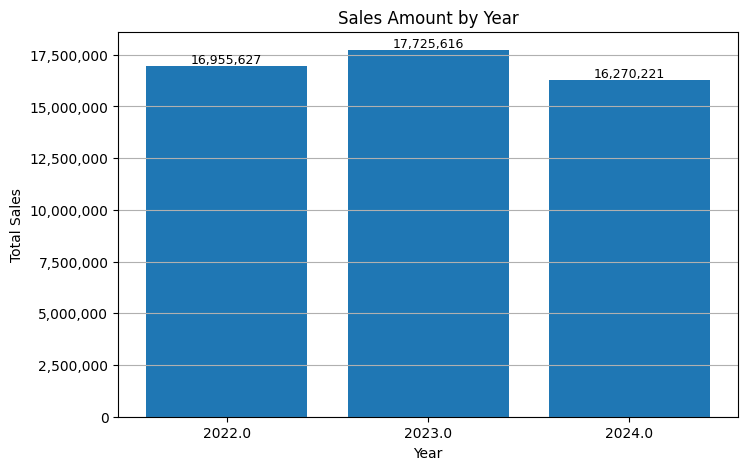

          country  sales_amount
0          Poland   10944017.72
1   United States    9003040.82
2  United Kingdom    8406319.02
3         Germany    8143697.78
4          France    5223329.58
5           Spain    4282312.39
6     Netherlands    2666216.14
7           Italy    2282532.11


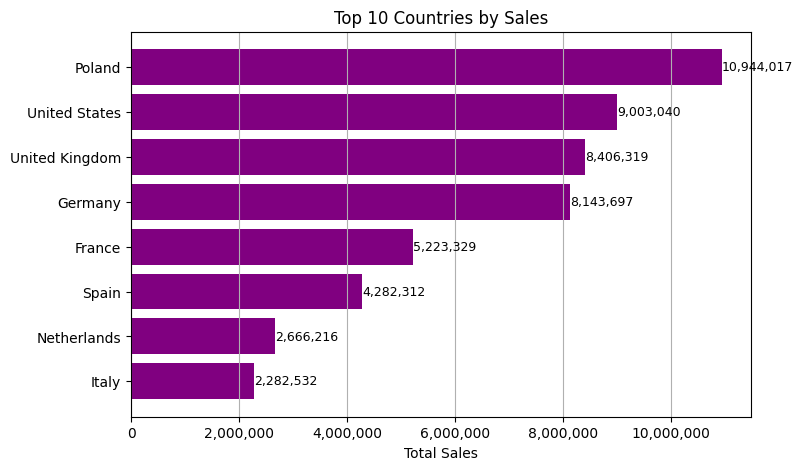

   customer_id first_name  last_name  total_spent  order_count
0         1166      James      Smith    162993.64            7
1          862  Charlotte      Brown    152865.94            8
2          428        Ava    Johnson    151223.93            9
3          665  Charlotte      Smith    149154.99            6
4          255  Agnieszka  Zielinska    146544.59            9


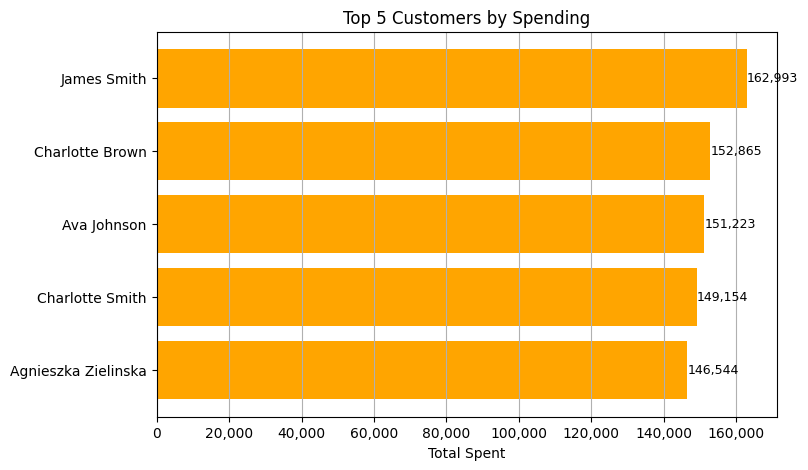

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy
import psycopg2

from sqlalchemy.engine import URL

connection_url = URL.create(
    "postgresql+psycopg2",
    username="postgres",
    password="password", 
    host="localhost",
    port="5432",
    database="ecommerce"
)

engine = create_engine(connection_url)
test_query = pd.read_sql("SELECT * FROM customers LIMIT 5;", engine)

test_query

query = """
SELECT SUM(oi.total_price) AS sales_amount, 
       EXTRACT(YEAR FROM o.order_date) AS year
FROM order_items oi
JOIN orders o ON oi.order_id = o.order_id
GROUP BY year
ORDER BY year;
"""

df_sales_year = pd.read_sql(query, engine)

import matplotlib.ticker as mticker
print(df_sales_year)

x = df_sales_year["year"].astype(str)
y = df_sales_year["sales_amount"]

plt.figure(figsize=(8,5))
plt.bar(x, y)
plt.title("Sales Amount by Year")
plt.xlabel("Year"); plt.ylabel("Total Sales")
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda v, _: f"{int(v):,}"))
for xi, yi in zip(x, y):
    plt.text(xi, yi, f"{int(yi):,}", ha="center", va="bottom", fontsize=9)
plt.grid(axis="y"); plt.show()

query_country = """
SELECT c.country, 
       SUM(oi.total_price) AS sales_amount
FROM order_items oi
JOIN orders o ON oi.order_id = o.order_id
JOIN customers c ON o.customer_id = c.customer_id
GROUP BY c.country
ORDER BY sales_amount DESC
LIMIT 10;
"""

df_sales_country = pd.read_sql(query_country, engine)
print(df_sales_country)


plt.figure(figsize=(8,5))
plt.barh(df_sales_country["country"], df_sales_country["sales_amount"], color="purple")
plt.title("Top 10 Countries by Sales")
plt.xlabel("Total Sales")
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda v, _: f"{int(v):,}"))
for yi, xi in zip(df_sales_country["country"], df_sales_country["sales_amount"]):
    plt.text(xi, yi, f"{int(xi):,}", va="center", fontsize=9)
plt.gca().invert_yaxis() 
plt.grid(axis="x")
plt.show()

query_top_customers = """
SELECT c.customer_id, 
       c.first_name, 
       c.last_name, 
       SUM(oi.total_price) AS total_spent,
       COUNT(DISTINCT oi.order_id) AS order_count
FROM customers c 
JOIN orders o ON o.customer_id = c.customer_id
JOIN order_items oi ON oi.order_id = o.order_id
WHERE o.order_status != 'Cancelled'
GROUP BY c.customer_id, c.first_name, c.last_name
ORDER BY total_spent DESC
LIMIT 5;
"""

df_top_customers = pd.read_sql(query_top_customers, engine)
print(df_top_customers)


plt.figure(figsize=(8,5))
plt.barh(df_top_customers["first_name"] + " " + df_top_customers["last_name"],
         df_top_customers["total_spent"],
         color="orange")
plt.title("Top 5 Customers by Spending")
plt.xlabel("Total Spent")
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda v, _: f"{int(v):,}"))

for name, value in zip(df_top_customers["first_name"] + " " + df_top_customers["last_name"],
                       df_top_customers["total_spent"]):
    plt.text(value, name, f"{int(value):,}", va="center", fontsize=9)

plt.gca().invert_yaxis()
plt.grid(axis="x")
plt.show()



